## Modelo ML

##### Librerias y limpieza

In [57]:
#Librerias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

URL = '/workspaces/Jese-David-Proyecto-Regresion-Logistica/data/processed/clean_ds.csv'
clean_ds = pd.read_csv(URL)
target ='y'

## **ESCALADO**

In [58]:
# columnas numéricas y categóricas después de limpieza
num_cols = X_train_clean.select_dtypes(include='number').columns.tolist()
cat_cols = X_train_clean.select_dtypes(exclude='number').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

____

## **MODELADO BASE**

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7308
           1       0.64      0.39      0.49       928

    accuracy                           0.91      8236
   macro avg       0.78      0.68      0.72      8236
weighted avg       0.89      0.91      0.90      8236

[[7101  207]
 [ 562  366]]


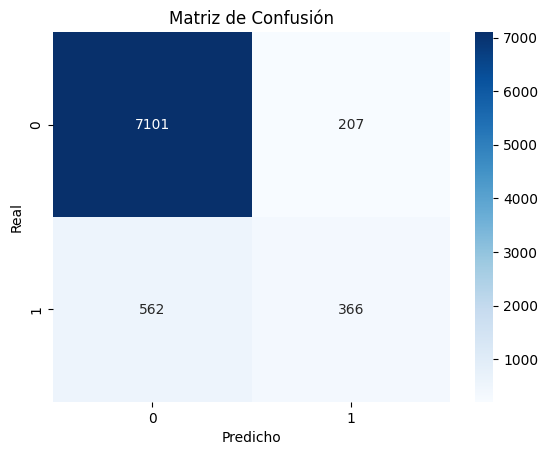

In [59]:
log_reg = LogisticRegression(max_iter=1000)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])
# entrenar SOLO con train
clf.fit(X_train_clean, y_train)

# predecir en test
y_pred = clf.predict(X_test_clean)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

___

## **MODELO OPTIMIZADO**

Mejores parámetros: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Mejor AUC en CV: 0.9368137643372231

== Resultados en el test con modelo optimizado ==
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      7308
           1       0.45      0.91      0.60       928

    accuracy                           0.86      8236
   macro avg       0.72      0.88      0.76      8236
weighted avg       0.93      0.86      0.88      8236

ROC-AUC: 0.9402760968140724


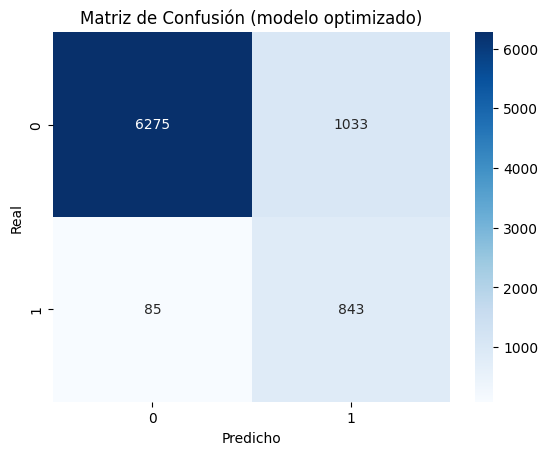

In [60]:
# Reutilizamos: preprocessor, X_train, y_train, X_test, y_test

base_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(max_iter=5000, class_weight='balanced'))
])

# 1. Definir rejilla de hiperparámetros
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l2'],          # con lbfgs solo se permite l2
    'logreg__solver': ['lbfgs']
}

# 2. GridSearch con ROC-AUC como métrica
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor AUC en CV:", grid.best_score_)

# 3. Modelo final optimizado
best_model = grid.best_estimator_

# 4. Evaluar en el test
y_prob_best = best_model.predict_proba(X_test)[:, 1]
y_pred_best = (y_prob_best >= 0.5).astype(int)

print("\n== Resultados en el test con modelo optimizado ==")
print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión (modelo optimizado)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

___

## **Analisis**

### Comparación de modelos de Regresión Logística

### 1. Modelos comparados

- **Modelo base**  
  - Regresión logística con pipeline de preprocesado.
  - Sin optimización de hiperparámetros específica para el desbalanceo.

- **Modelo optimizado**  
  - Pipeline de preprocesado + `LogisticRegression(max_iter=5000, class_weight='balanced')`.
  - Búsqueda de hiperparámetros con `GridSearchCV` optimizando **ROC-AUC**.
  - Mejores parámetros encontrados:
    - `logreg__C = 1`
    - `logreg__penalty = 'l2'`
    - `logreg__solver = 'lbfgs'`
  - Mejor AUC en validación cruzada (CV): **0.9368**

---

### 2. Resultados en el conjunto de test

#### 2.1. Modelo base

- **Métricas por clase**

| Clase | precision | recall | f1-score | support |
|------:|:---------:|:------:|:--------:|:-------:|
| 0 (no) | 0.93 | 0.97 | 0.95 | 7308 |
| 1 (sí) | 0.64 | 0.39 | 0.49 | 928 |

- **Métricas globales**

- Accuracy: **0.91**  
- Macro avg F1: **0.72**  
- Weighted avg F1: **0.90**

**Conclusión modelo base:**  
El modelo consigue una *accuracy* alta porque clasifica muy bien la clase mayoritaria (0), pero el **recall de la clase positiva (1) es solo 0.39**, es decir, se pierde más de la mitad de los clientes que realmente aceptarían la campaña.

---

#### 2.2. Modelo optimizado

- **Métricas por clase**

| Clase | precision | recall | f1-score | support |
|------:|:---------:|:------:|:--------:|:-------:|
| 0 (no) | 0.99 | 0.86 | 0.92 | 7308 |
| 1 (sí) | 0.45 | 0.91 | 0.60 | 928 |

- **Métricas globales**

- Accuracy: **0.86**  
- Macro avg F1: **0.76**  
- Weighted avg F1: **0.88**  
- ROC–AUC en test: **0.94**

**Conclusión modelo optimizado:**  
El modelo optimizado **incrementa de forma muy importante el recall de la clase positiva (de 0.39 a 0.91)**, es decir, ahora es capaz de capturar la gran mayoría de los clientes que aceptarían la campaña. A cambio, disminuye la precisión de la
